In [1]:
import pathlib
import random
from typing import Literal


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
NAMES_FILE = "names.txt"
TERM_TOK = "."
TORCH_SEED = 2147483647
SEED = 42
CONTEXT_SIZE = 3
EMBEDDING_SIZE = 10
W1_NUM_NEURONS = 200
BATCH_SIZE = 32
NUM_EPOCHS_DEV = 1000
NUM_EPOCHS_TRAIN = 200000
LR_DECAY_THRESHOLD = 100000
BATCH_NORM_CONSTS_RUNNING_MOMENTUM = 1e-4
assert LR_DECAY_THRESHOLD < NUM_EPOCHS_TRAIN
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1.0

random.seed(SEED)
torch.manual_seed(TORCH_SEED)
# device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
device = torch.device("cpu")
device

device(type='cpu')

In [3]:
words = [line.strip() for line in pathlib.Path(NAMES_FILE).open("r").readlines()]
random.shuffle(words)
chars = [TERM_TOK] + sorted(list(set("".join(words))))
vocab_size = len(chars)
stoi = {s: i for i, s in enumerate(chars)}
itos = chars

In [4]:
# build the dataset
def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for w in words:
        context = [0] * CONTEXT_SIZE
        for ch in w + TERM_TOK:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(TRAIN_SPLIT * len(words))
n2 = int((TRAIN_SPLIT + VAL_SPLIT) * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
C = torch.randn((vocab_size, EMBEDDING_SIZE), device=device)
# kaiming init
W1 = (
    torch.randn((CONTEXT_SIZE * EMBEDDING_SIZE, W1_NUM_NEURONS), device=device)
    * (5 / 3)
    / (CONTEXT_SIZE * EMBEDDING_SIZE) ** 0.5
)
# no need because batchnorm
# b1 = torch.randn(W1_NUM_NEURONS, device=device) * 0.01
W2 = torch.randn((W1_NUM_NEURONS, vocab_size), device=device) * 0.01
b2 = torch.randn(vocab_size, device=device) * 0
bngain = torch.ones((1, W1_NUM_NEURONS), device=device)
bnbias = torch.zeros((1, W1_NUM_NEURONS), device=device)
bnmean_running = torch.zeros((1, W1_NUM_NEURONS), device=device)
bnstd_running = torch.ones((1, W1_NUM_NEURONS), device=device)
parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad_(True)
print(f"num of parameters in total: {sum(p.numel() for p in parameters)}")


def forward(X: torch.Tensor) -> torch.Tensor:
    emb = C[X]
    batch_size = len(emb)
    embcat = emb.view(batch_size, -1)
    hpreact = embcat @ W1  # + b1

    # batchnorm: normalize hpreact to gaussian dist with mean 0, std 1, and scale and shift
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # accumulate estimated running mean and std
    with torch.no_grad():
        bnmean_running.mul_(1 - BATCH_NORM_CONSTS_RUNNING_MOMENTUM).add_(BATCH_NORM_CONSTS_RUNNING_MOMENTUM * bnmeani)
        bnstd_running.mul_(1 - BATCH_NORM_CONSTS_RUNNING_MOMENTUM).add_(BATCH_NORM_CONSTS_RUNNING_MOMENTUM * bnstdi)

    # non-linearity
    h = hpreact.tanh()
    logits = h @ W2 + b2
    return logits


def evaluate(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    logits = forward(X)
    loss = F.cross_entropy(logits, target=Y)
    return loss


@torch.no_grad()
def split_loss(split: Literal["train", "dev", "test"]) -> torch.Tensor:
    x, y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    loss = evaluate(x, y)
    return loss

num of parameters in total: 12097


In [6]:
print(split_loss("train").item())
print(split_loss("dev").item())
print(split_loss("test").item())

3.298630475997925
3.298227548599243
3.2983219623565674


step       0/ 200000: train loss 3.3239
step   10000/ 200000: train loss 2.0322
step   20000/ 200000: train loss 2.5675
step   30000/ 200000: train loss 2.0125
step   40000/ 200000: train loss 2.2446
step   50000/ 200000: train loss 1.8897
step   60000/ 200000: train loss 2.0785
step   70000/ 200000: train loss 2.3681
step   80000/ 200000: train loss 2.2918
step   90000/ 200000: train loss 2.0238
step  100000/ 200000: train loss 2.3673
step  110000/ 200000: train loss 2.3132
step  120000/ 200000: train loss 1.6414
step  130000/ 200000: train loss 1.9311
step  140000/ 200000: train loss 2.2231
step  150000/ 200000: train loss 2.0027
step  160000/ 200000: train loss 2.0997
step  170000/ 200000: train loss 2.4949
step  180000/ 200000: train loss 2.0199
step  190000/ 200000: train loss 2.1707


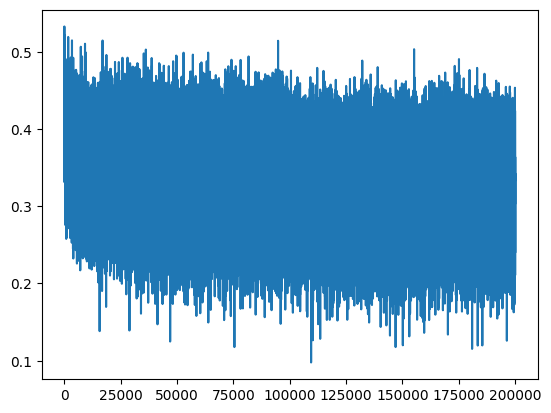

In [7]:
# train
lossi = []
best_lr = 0.1

for i in range(NUM_EPOCHS_TRAIN):
    # minibatch construct
    idx = torch.randint(low=0, high=len(Xtr), size=(BATCH_SIZE,))
    # forward pass and calculate loss
    loss = evaluate(Xtr[idx], Ytr[idx])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = best_lr if i < LR_DECAY_THRESHOLD else best_lr * 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"step {i:7d}/{NUM_EPOCHS_TRAIN:7d}: train loss {loss.item():.4f}")
    lossi.append(loss.log10().item())

plt.plot(lossi)

In [8]:
# validate on dev and test sets
print(split_loss("dev").item())
print(split_loss("test").item())

2.1054909229278564
2.107012987136841


In [11]:
# use batchnorm running mean and std during training for generation
def forward_with_batchnorm_consts(X: torch.Tensor) -> torch.Tensor:
    emb = C[X]
    batch_size = len(emb)
    embcat = emb.view(batch_size, -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
    h = hpreact.tanh()
    logits = h @ W2 + b2
    return logits


# sample
with torch.no_grad():
    for _ in range(20):
        context = [0] * CONTEXT_SIZE
        out = ""
        while True:
            logits = forward_with_batchnorm_consts(torch.tensor([context]))
            probs = logits.softmax(dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out += itos[ix]
            if ix == 0:
                break
        print(out)

caton.
traxtonni.
arrus.
davarjane.
kacy.
kenzien.
tit.
shristophena.
jair.
endy.
nikenslannesiah.
gwenestlee.
eri.
grah.
emi.
prolitumba.
maniyah.
aiban.
zamarie.
asen.
